## Inpatient Sensors Machine Learning BBS

Adam P. Horin, PhD

July 21, 2020


This code is the first analysis for the Risk of Fall part of the AIR model:

1. Ambulation: predict and automate outcomes of gait from sensor data and clinical outcomes.

2. Independence: predict and automate outcomes of independence from sensor data and clinical outcomes.

#### 3. Risk of Falls: predict and automate fall risk from sensor data and clinical outcomes.

In [211]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as seabornInstance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
from pathlib import Path
%matplotlib inline


In [212]:
# To display rows and columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [213]:
# Load data

fulldata = pd.read_csv(r"C:\Users\ahorin\Documents\Inpatient Sensor Code AH\Machine_Learning_BBS\FeatureMatrix_BBS_ALL.csv", sep=',')
fulldata.head()


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,11,12,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,subject,group,dob,admission_date,doe,age,sex,race,height_cm,weight_kg,lifestyle,highest_grade,highest_degree,cva_date,cva_to_admission_time,lesion_location,hemiparesis,lesion_distribution,lesion_location.1,etiology,stay_length,language_dx_yn,voice_dx_severity,language_dx,cog_comm_dx,cog_comm_type,cog_comm_severity,dysphagia,dysphagia_severity,diet_admission,diet_discharge,speech_dx_yn,speech_severity,speech_dx,cardiac_hx,afib,HTN,HLD,OSA,PVD,DM,other_neuro,neuro_specify,trach,renal,druguse_hx,movement_disorders,comorbidities,beta_blockers,BBS_total,BBS_subscore,6MWT,10MWT_SSV,10MWT_FV,TUG,FIM_motor_admission,FIM_cog_admission,FIM_admission,FIM_motor_discharge,FIM_cog_discharge,FIM_discharge,activity,session,trial_No,cutoff,trialtime,SC_Gyr_x_mean,SC_Gyr_y_mean,SC_Gyr_z_mean,SC_Gyr_norm_mean,SC_Gyr_x_range,SC_Gyr_y_range,SC_Gyr_z_range,SC_Gyr_norm_range,SC_Gyr_x_rms,SC_Gyr_y_rms,SC_Gyr_z_rms,SC_Gyr_norm_rms,SC_Gyr_x_std,SC_Gyr_y_std,SC_Gyr_z_std,SC_Gyr_norm_std,SC_Gyr_x_skew,SC_Gyr_y_skew,SC_Gyr_z_skew,SC_Gyr_norm_skew,SC_Gyr_x_kurtosis,SC_Gyr_y_kurtosis,SC_Gyr_z_kurtosis,SC_Gyr_norm_kurtosis,dSC_Gyr_x_mean,dSC_Gyr_y_mean,dSC_Gyr_z_mean,dSC_Gyr_norm_mean,dSC_Gyr_x_range,dSC_Gyr_y_range,dSC_Gyr_z_range,dSC_Gyr_norm_range,dSC_Gyr_x_rms,dSC_Gyr_y_rms,dSC_Gyr_z_rms,dSC_Gyr_norm_rms,dSC_Gyr_x_std,dSC_Gyr_y_std,dSC_Gyr_z_std,dSC_Gyr_norm_std,dSC_Gyr_x_skew,dSC_Gyr_y_skew,dSC_Gyr_z_skew,dSC_Gyr_norm_skew,dSC_Gyr_x_kurtosis,dSC_Gyr_y_kurtosis,dSC_Gyr_z_kurtosis,dSC_Gyr_norm_kurtosis,SC_Gyr_corr_xy,SC_Gyr_corr_xz,SC_Gyr_corr_yz,SC_Gyr_x_SamEn,SC_Gyr_y_SamEn,SC_Gyr_z_SamEn,SC_Gyr_norm_SamEn,SC_Gyr_x_DAmp,SC_Gyr_x_DFreq,SC_Gyr_x_PSD_mean,SC_Gyr_x_PSD_std,SC_Gyr_x_PSD_skew,SC_Gyr_x_PSD_kurtosis,SC_Gyr_y_DAmp,SC_Gyr_y_DFreq,SC_Gyr_y_PSD_mean,SC_Gyr_y_PSD_std,SC_Gyr_y_PSD_skew,SC_Gyr_y_PSD_kurtosis,SC_Gyr_z_DAmp,SC_Gyr_z_DFreq,SC_Gyr_z_PSD_mean,SC_Gyr_z_PSD_std,SC_Gyr_z_PSD_skew,SC_Gyr_z_PSD_kurtosis,SC_Gyr_norm_DAmp,SC_Gyr_norm_DFreq,SC_Gyr_norm_PSD_mean,SC_Gyr_norm_PSD_std,SC_Gyr_norm_PSD_skew,SC_Gyr_norm_PSD_kurtosis,f50_ML,f50_AP,f95_ML,f95_AP,spectral_centroid_AP,spectral_centroid_ML,max_accAP,max_accML,mean_accAP,mean_accML,rms_AP,rms_ML,jerk_AP,jerk_ML,mean_velAP,mean_velML,length_swayAPAcc,length_swayMLAcc
0,CVA01,CVA,19926,43195.0,43201,63,F,White/Non-Hispanic,172.72,62.2,Sedentary,12,HS,43162.0,33.0,R,L,BG,Brainstem,hemmorrage,19,Y,Mild,Undifferentiated aphasia fluent,N,NaN,NaN,N,absent,regular/thin,regular/thin,N,Mild - Moderate,Aphonia - dysphonia,Y,0,Y,N,Y,N,N,Y,L-SDH,N,Y,N,N,0,Y,15.0,3.0,NaN,NaN,NaN,NaN,24.0,25.0,49.0,57.0,28.0,85.0,BBS,1,N01,15,7.552,-4.716133,-1.381296,1.419154,14.382117,83.619435,43.396656,20.019837,64.407506,18.552176,7.386365,3.846786,20.335668,17.980697,7.271417,3.583007,14.407287,-1.715095,-0.549022,0.22945,1.847934,5.1782,3.927147,3.476109,5.725774,0.299038,-0.913278,0.040411,0.919016,730.524269,740.063839,308.995769,592.989453,95.014752,119.273578,54.812123,99.244608,95.216225,119.523578,54.928606,99.451278,0.850132,-0.084109,-0.090159,-0.174292,7.113135,3.240713,3.382294,3.55323,-0.20638,-0.438004,0.42344,0.425482,1.32827,1.020944,0.668752,14.387463,0.12207,0.835675,2.138409,4.325629,22.46279,3.541275,2.075195,0.561607,0.70492,2.094086,7.172727,2.627651,0.0,0.274528,0.406291,3.076044,14.998244,26.629388,0.0,0.907735,2.814541,6.859002,57.708426,0.39557,0.263713,2.505274,0.659283,0.331768,0.837681,4.288448,1.08988,2.073417,0.266545,2.356938,0.338627,2.568202,1.582116,2.204157,0.259735,19.395059,11.948143
1,CVA01,CVA,19926,43195.0,43201,63,F,White/Non-Hispanic,172.72,62.2,Sedentary,12,HS,43162.0,33.0,R,L,BG,Brainstem,hemmorrage,19,Y,Mild,Undifferentiated aphasia fluent,N,NaN,NaN,N,absent,regular/thin,regular/thin,N,Mild - Moderate,Aphonia - dysphonia,Y,0,Y,N,Y,N,N,Y,L-SDH,N,Y,N,N,0,Y,15.0,3.0,NaN,NaN,NaN,NaN,24.0,25.0,49.0,57.0,28.0,85.0,BBS,1,N01,30,7.552,-4.716133,-1.381296,1.419154,14.382117,83.619435,43.396656,20.019837,64.407506,18.552176,7.386365,3.846786,20.335668,17.980697,7.271417,3.583007,14.4

## Defining Risk of Falls

Risk of falls has previously been defined based on walking and balance outcomes in people with stroke. For this analysis we are defining risk of falls (fallrisk) as a dichotomous outcome of Y and N. The cutoff for fallrisk will be based using the length of time of each participants TUG score (1). Other papers have used used TUG cutoffs of 15 seconds (2) and 20 seconds (3).

(1) Used standing on one leg as well, but the cut off time is longer than the BBS task. So we are just using the TUG score:

Y = TUG >= 11 seconds

N = TUG < 11 seconds

1. Ishigaki N, Kimura T, Usui Y, Aoki K, Narita N, Shimizu M, Hara K, Ogihara N,
Nakamura K, Kato H, Ohira M, Yokokawa Y, Miyoshi K, Murakami N, Okada S,
Nakamura T, Saito N: Analysis of pelvic movement in the elderly during
walking using a posture monitoring system equipped with a triaxial
accelerometer and a gyroscope. J Biomech 2011, 44:1788–1792

2. Bautmans I, Jansen B, van Keymolen B, Mets T: Reliability and clinical
correlates of 3D-accelerometry based gait analysis outcomes according
to age and fall-risk. Gait Posture 2011, 33:366–372

3. Marschollek M, Wolf K-H, Gietzelt M, Nemitz G, Meyer Zu Schwabedissen H,
Haux R: Assessing elderly persons’ fall risk using spectral analysis on
accelerometric data-a clinical evaluation study. In 30th Annual
International IEEE EMBS Conference: 20-24 August 2008. Vancouver;
2008:3682–3685.

## *Using the TUG won't work for this data set because we only have 28 participants with a TUG score.

Everyone has a total BBS score, so we can use a cut off of <= 29 to define fall risk (4).

4. Maeda, N et al (2009). Predicting the probability for fall incidene in stroke patients using the Berg Balance Scale.




In [214]:
# Add fallrisk variable

fulldata['fallrisk'] = np.where(fulldata['BBS_total']<= 29, 1, 0) # 1 is yes for fall risk, 0 is no for fall risk
fulldata.head()


,subject,group,dob,admission_date,doe,age,sex,race,height_cm,weight_kg,lifestyle,highest_grade,highest_degree,cva_date,cva_to_admission_time,lesion_location,hemiparesis,lesion_distribution,lesion_location.1,etiology,stay_length,language_dx_yn,voice_dx_severity,language_dx,cog_comm_dx,cog_comm_type,cog_comm_severity,dysphagia,dysphagia_severity,diet_admission,diet_discharge,speech_dx_yn,speech_severity,speech_dx,cardiac_hx,afib,HTN,HLD,OSA,PVD,DM,other_neuro,neuro_specify,trach,renal,druguse_hx,movement_disorders,comorbidities,beta_blockers,BBS_total,BBS_subscore,6MWT,10MWT_SSV,10MWT_FV,TUG,FIM_motor_admission,FIM_cog_admission,FIM_admission,FIM_motor_discharge,FIM_cog_discharge,FIM_discharge,activity,session,trial_No,cutoff,trialtime,SC_Gyr_x_mean,SC_Gyr_y_mean,SC_Gyr_z_mean,SC_Gyr_norm_mean,SC_Gyr_x_range,SC_Gyr_y_range,SC_Gyr_z_range,SC_Gyr_norm_range,SC_Gyr_x_rms,SC_Gyr_y_rms,SC_Gyr_z_rms,SC_Gyr_norm_rms,SC_Gyr_x_std,SC_Gyr_y_std,SC_Gyr_z_std,SC_Gyr_norm_std,SC_Gyr_x_skew,SC_Gyr_y_skew,SC_Gyr_z_skew,SC_Gyr_norm_skew,SC_Gyr_x_kurtosis,SC_Gyr_y_kurtosis,SC_Gyr_z_kurtosis,SC_Gyr_norm_kurtosis,dSC_Gyr_x_mean,dSC_Gyr_y_mean,dSC_Gyr_z_mean,dSC_Gyr_norm_mean,dSC_Gyr_x_range,dSC_Gyr_y_range,dSC_Gyr_z_range,dSC_Gyr_norm_range,dSC_Gyr_x_rms,dSC_Gyr_y_rms,dSC_Gyr_z_rms,dSC_Gyr_norm_rms,dSC_Gyr_x_std,dSC_Gyr_y_std,dSC_Gyr_z_std,dSC_Gyr_norm_std,dSC_Gyr_x_skew,dSC_Gyr_y_skew,dSC_Gyr_z_skew,dSC_Gyr_norm_skew,dSC_Gyr_x_kurtosis,dSC_Gyr_y_kurtosis,dSC_Gyr_z_kurtosis,dSC_Gyr_norm_kurtosis,SC_Gyr_corr_xy,SC_Gyr_corr_xz,SC_Gyr_corr_yz,SC_Gyr_x_SamEn,SC_Gyr_y_SamEn,SC_Gyr_z_SamEn,SC_Gyr_norm_SamEn,SC_Gyr_x_DAmp,SC_Gyr_x_DFreq,SC_Gyr_x_PSD_mean,SC_Gyr_x_PSD_std,SC_Gyr_x_PSD_skew,SC_Gyr_x_PSD_kurtosis,SC_Gyr_y_DAmp,SC_Gyr_y_DFreq,SC_Gyr_y_PSD_mean,SC_Gyr_y_PSD_std,SC_Gyr_y_PSD_skew,SC_Gyr_y_PSD_kurtosis,SC_Gyr_z_DAmp,SC_Gyr_z_DFreq,SC_Gyr_z_PSD_mean,SC_Gyr_z_PSD_std,SC_Gyr_z_PSD_skew,SC_Gyr_z_PSD_kurtosis,SC_Gyr_norm_DAmp,SC_Gyr_norm_DFreq,SC_Gyr_norm_PSD_mean,SC_Gyr_norm_PSD_std,SC_Gyr_norm_PSD_skew,SC_Gyr_norm_PSD_kurtosis,f50_ML,f50_AP,f95_ML,f95_AP,spectral_centroid_AP,spectral_centroid_ML,max_accAP,max_accML,mean_accAP,mean_accML,rms_AP,rms_ML,jerk_AP,jerk_ML,mean_velAP,mean_velML,length_swayAPAcc,length_swayMLAcc,fallrisk
0,CVA01,CVA,19926,43195.0,43201,63,F,White/Non-Hispanic,172.72,62.2,Sedentary,12,HS,43162.0,33.0,R,L,BG,Brainstem,hemmorrage,19,Y,Mild,Undifferentiated aphasia fluent,N,NaN,NaN,N,absent,regular/thin,regular/thin,N,Mild - Moderate,Aphonia - dysphonia,Y,0,Y,N,Y,N,N,Y,L-SDH,N,Y,N,N,0,Y,15.0,3.0,NaN,NaN,NaN,NaN,24.0,25.0,49.0,57.0,28.0,85.0,BBS,1,N01,15,7.552,-4.716133,-1.381296,1.419154,14.382117,83.619435,43.396656,20.019837,64.407506,18.552176,7.386365,3.846786,20.335668,17.980697,7.271417,3.583007,14.407287,-1.715095,-0.549022,0.22945,1.847934,5.1782,3.927147,3.476109,5.725774,0.299038,-0.913278,0.040411,0.919016,730.524269,740.063839,308.995769,592.989453,95.014752,119.273578,54.812123,99.244608,95.216225,119.523578,54.928606,99.451278,0.850132,-0.084109,-0.090159,-0.174292,7.113135,3.240713,3.382294,3.55323,-0.20638,-0.438004,0.42344,0.425482,1.32827,1.020944,0.668752,14.387463,0.12207,0.835675,2.138409,4.325629,22.46279,3.541275,2.075195,0.561607,0.70492,2.094086,7.172727,2.627651,0.0,0.274528,0.406291,3.076044,14.998244,26.629388,0.0,0.907735,2.814541,6.859002,57.708426,0.39557,0.263713,2.505274,0.659283,0.331768,0.837681,4.288448,1.08988,2.073417,0.266545,2.356938,0.338627,2.568202,1.582116,2.204157,0.259735,19.395059,11.948143,1
1,CVA01,CVA,19926,43195.0,43201,63,F,White/Non-Hispanic,172.72,62.2,Sedentary,12,HS,43162.0,33.0,R,L,BG,Brainstem,hemmorrage,19,Y,Mild,Undifferentiated aphasia fluent,N,NaN,NaN,N,absent,regular/thin,regular/thin,N,Mild - Moderate,Aphonia - dysphonia,Y,0,Y,N,Y,N,N,Y,L-SDH,N,Y,N,N,0,Y,15.0,3.0,NaN,NaN,NaN,NaN,24.0,25.0,49.0,57.0,28.0,85.0,BBS,1,N01,30,7.552,-4.716133,-1.381296,1.419154,14.382117,83.619435,43.396656,20.019837,64.407506,18.552176,7.386365,3.846786,20.335668,17.980697,7.271417,3.

In [215]:
# We are interested in the discharge fall risk variable for the prediction model
# Make a new dataframe with subject ID and fall risk, only for session 4

fallrisk_data = fulldata[fulldata.trial_No == 'N02']
fallrisk_data = fallrisk_data[fallrisk_data.session == 4]
fallrisk_data = fallrisk_data[fallrisk_data.cutoff == 200]
fallrisk_data = pd.DataFrame(fallrisk_data, columns = ['subject', 'session', 'fallrisk'])
fallrisk_data.columns = ['subject', 'session', 'fallrisk_discharge']
fallrisk_data.head()



,subject,session,fallrisk_discharge
395,CVA01,4,1
899,CVA02,4,0
1403,CVA03,4,1
1907,CVA04,4,1
2411,CVA05,4,0


In [216]:
# Merge the fallrisk_discharge variable with the full data based on subject id
fulldata['fallrisk_discharge'] = fulldata.subject.map(fallrisk_data.set_index('subject')['fallrisk_discharge'])
fulldata.head()

,subject,group,dob,admission_date,doe,age,sex,race,height_cm,weight_kg,lifestyle,highest_grade,highest_degree,cva_date,cva_to_admission_time,lesion_location,hemiparesis,lesion_distribution,lesion_location.1,etiology,stay_length,language_dx_yn,voice_dx_severity,language_dx,cog_comm_dx,cog_comm_type,cog_comm_severity,dysphagia,dysphagia_severity,diet_admission,diet_discharge,speech_dx_yn,speech_severity,speech_dx,cardiac_hx,afib,HTN,HLD,OSA,PVD,DM,other_neuro,neuro_specify,trach,renal,druguse_hx,movement_disorders,comorbidities,beta_blockers,BBS_total,BBS_subscore,6MWT,10MWT_SSV,10MWT_FV,TUG,FIM_motor_admission,FIM_cog_admission,FIM_admission,FIM_motor_discharge,FIM_cog_discharge,FIM_discharge,activity,session,trial_No,cutoff,trialtime,SC_Gyr_x_mean,SC_Gyr_y_mean,SC_Gyr_z_mean,SC_Gyr_norm_mean,SC_Gyr_x_range,SC_Gyr_y_range,SC_Gyr_z_range,SC_Gyr_norm_range,SC_Gyr_x_rms,SC_Gyr_y_rms,SC_Gyr_z_rms,SC_Gyr_norm_rms,SC_Gyr_x_std,SC_Gyr_y_std,SC_Gyr_z_std,SC_Gyr_norm_std,SC_Gyr_x_skew,SC_Gyr_y_skew,SC_Gyr_z_skew,SC_Gyr_norm_skew,SC_Gyr_x_kurtosis,SC_Gyr_y_kurtosis,SC_Gyr_z_kurtosis,SC_Gyr_norm_kurtosis,dSC_Gyr_x_mean,dSC_Gyr_y_mean,dSC_Gyr_z_mean,dSC_Gyr_norm_mean,dSC_Gyr_x_range,dSC_Gyr_y_range,dSC_Gyr_z_range,dSC_Gyr_norm_range,dSC_Gyr_x_rms,dSC_Gyr_y_rms,dSC_Gyr_z_rms,dSC_Gyr_norm_rms,dSC_Gyr_x_std,dSC_Gyr_y_std,dSC_Gyr_z_std,dSC_Gyr_norm_std,dSC_Gyr_x_skew,dSC_Gyr_y_skew,dSC_Gyr_z_skew,dSC_Gyr_norm_skew,dSC_Gyr_x_kurtosis,dSC_Gyr_y_kurtosis,dSC_Gyr_z_kurtosis,dSC_Gyr_norm_kurtosis,SC_Gyr_corr_xy,SC_Gyr_corr_xz,SC_Gyr_corr_yz,SC_Gyr_x_SamEn,SC_Gyr_y_SamEn,SC_Gyr_z_SamEn,SC_Gyr_norm_SamEn,SC_Gyr_x_DAmp,SC_Gyr_x_DFreq,SC_Gyr_x_PSD_mean,SC_Gyr_x_PSD_std,SC_Gyr_x_PSD_skew,SC_Gyr_x_PSD_kurtosis,SC_Gyr_y_DAmp,SC_Gyr_y_DFreq,SC_Gyr_y_PSD_mean,SC_Gyr_y_PSD_std,SC_Gyr_y_PSD_skew,SC_Gyr_y_PSD_kurtosis,SC_Gyr_z_DAmp,SC_Gyr_z_DFreq,SC_Gyr_z_PSD_mean,SC_Gyr_z_PSD_std,SC_Gyr_z_PSD_skew,SC_Gyr_z_PSD_kurtosis,SC_Gyr_norm_DAmp,SC_Gyr_norm_DFreq,SC_Gyr_norm_PSD_mean,SC_Gyr_norm_PSD_std,SC_Gyr_norm_PSD_skew,SC_Gyr_norm_PSD_kurtosis,f50_ML,f50_AP,f95_ML,f95_AP,spectral_centroid_AP,spectral_centroid_ML,max_accAP,max_accML,mean_accAP,mean_accML,rms_AP,rms_ML,jerk_AP,jerk_ML,mean_velAP,mean_velML,length_swayAPAcc,length_swayMLAcc,fallrisk,fallrisk_discharge
0,CVA01,CVA,19926,43195.0,43201,63,F,White/Non-Hispanic,172.72,62.2,Sedentary,12,HS,43162.0,33.0,R,L,BG,Brainstem,hemmorrage,19,Y,Mild,Undifferentiated aphasia fluent,N,NaN,NaN,N,absent,regular/thin,regular/thin,N,Mild - Moderate,Aphonia - dysphonia,Y,0,Y,N,Y,N,N,Y,L-SDH,N,Y,N,N,0,Y,15.0,3.0,NaN,NaN,NaN,NaN,24.0,25.0,49.0,57.0,28.0,85.0,BBS,1,N01,15,7.552,-4.716133,-1.381296,1.419154,14.382117,83.619435,43.396656,20.019837,64.407506,18.552176,7.386365,3.846786,20.335668,17.980697,7.271417,3.583007,14.407287,-1.715095,-0.549022,0.22945,1.847934,5.1782,3.927147,3.476109,5.725774,0.299038,-0.913278,0.040411,0.919016,730.524269,740.063839,308.995769,592.989453,95.014752,119.273578,54.812123,99.244608,95.216225,119.523578,54.928606,99.451278,0.850132,-0.084109,-0.090159,-0.174292,7.113135,3.240713,3.382294,3.55323,-0.20638,-0.438004,0.42344,0.425482,1.32827,1.020944,0.668752,14.387463,0.12207,0.835675,2.138409,4.325629,22.46279,3.541275,2.075195,0.561607,0.70492,2.094086,7.172727,2.627651,0.0,0.274528,0.406291,3.076044,14.998244,26.629388,0.0,0.907735,2.814541,6.859002,57.708426,0.39557,0.263713,2.505274,0.659283,0.331768,0.837681,4.288448,1.08988,2.073417,0.266545,2.356938,0.338627,2.568202,1.582116,2.204157,0.259735,19.395059,11.948143,1,1
1,CVA01,CVA,19926,43195.0,43201,63,F,White/Non-Hispanic,172.72,62.2,Sedentary,12,HS,43162.0,33.0,R,L,BG,Brainstem,hemmorrage,19,Y,Mild,Undifferentiated aphasia fluent,N,NaN,NaN,N,absent,regular/thin,regular/thin,N,Mild - Moderate,Aphonia - dysphonia,Y,0,Y,N,Y,N,N,Y,L-SDH,N,Y,N,N,0,Y,15.0,3.0,NaN,NaN,NaN,NaN,24.0,25.0,49.0,57.0,28.0,85.0,BBS,1,N01,30,7.552,-4.716133,-1.381296,1.419154,14.382117,83.619435,43.396656,20.019837,64.407506,18.552176,7.386365,3.846786,20.335668,

In [217]:
# print variable list
fulldata_cols = fulldata.columns
fulldata_cols[:,]


Index(['subject', 'group', 'dob', 'admission_date', 'doe', 'age', 'sex',
       'race', 'height_cm', 'weight_kg',
       ...
       'rms_AP', 'rms_ML', 'jerk_AP', 'jerk_ML', 'mean_velAP', 'mean_velML',
       'length_swayAPAcc', 'length_swayMLAcc', 'fallrisk',
       'fallrisk_discharge'],
      dtype='object', length=165)

In [218]:
# The full data without time cuttoffs was defined as cutoff = 200
data = fulldata[fulldata.cutoff == 200]
data.head()

,subject,group,dob,admission_date,doe,age,sex,race,height_cm,weight_kg,lifestyle,highest_grade,highest_degree,cva_date,cva_to_admission_time,lesion_location,hemiparesis,lesion_distribution,lesion_location.1,etiology,stay_length,language_dx_yn,voice_dx_severity,language_dx,cog_comm_dx,cog_comm_type,cog_comm_severity,dysphagia,dysphagia_severity,diet_admission,diet_discharge,speech_dx_yn,speech_severity,speech_dx,cardiac_hx,afib,HTN,HLD,OSA,PVD,DM,other_neuro,neuro_specify,trach,renal,druguse_hx,movement_disorders,comorbidities,beta_blockers,BBS_total,BBS_subscore,6MWT,10MWT_SSV,10MWT_FV,TUG,FIM_motor_admission,FIM_cog_admission,FIM_admission,FIM_motor_discharge,FIM_cog_discharge,FIM_discharge,activity,session,trial_No,cutoff,trialtime,SC_Gyr_x_mean,SC_Gyr_y_mean,SC_Gyr_z_mean,SC_Gyr_norm_mean,SC_Gyr_x_range,SC_Gyr_y_range,SC_Gyr_z_range,SC_Gyr_norm_range,SC_Gyr_x_rms,SC_Gyr_y_rms,SC_Gyr_z_rms,SC_Gyr_norm_rms,SC_Gyr_x_std,SC_Gyr_y_std,SC_Gyr_z_std,SC_Gyr_norm_std,SC_Gyr_x_skew,SC_Gyr_y_skew,SC_Gyr_z_skew,SC_Gyr_norm_skew,SC_Gyr_x_kurtosis,SC_Gyr_y_kurtosis,SC_Gyr_z_kurtosis,SC_Gyr_norm_kurtosis,dSC_Gyr_x_mean,dSC_Gyr_y_mean,dSC_Gyr_z_mean,dSC_Gyr_norm_mean,dSC_Gyr_x_range,dSC_Gyr_y_range,dSC_Gyr_z_range,dSC_Gyr_norm_range,dSC_Gyr_x_rms,dSC_Gyr_y_rms,dSC_Gyr_z_rms,dSC_Gyr_norm_rms,dSC_Gyr_x_std,dSC_Gyr_y_std,dSC_Gyr_z_std,dSC_Gyr_norm_std,dSC_Gyr_x_skew,dSC_Gyr_y_skew,dSC_Gyr_z_skew,dSC_Gyr_norm_skew,dSC_Gyr_x_kurtosis,dSC_Gyr_y_kurtosis,dSC_Gyr_z_kurtosis,dSC_Gyr_norm_kurtosis,SC_Gyr_corr_xy,SC_Gyr_corr_xz,SC_Gyr_corr_yz,SC_Gyr_x_SamEn,SC_Gyr_y_SamEn,SC_Gyr_z_SamEn,SC_Gyr_norm_SamEn,SC_Gyr_x_DAmp,SC_Gyr_x_DFreq,SC_Gyr_x_PSD_mean,SC_Gyr_x_PSD_std,SC_Gyr_x_PSD_skew,SC_Gyr_x_PSD_kurtosis,SC_Gyr_y_DAmp,SC_Gyr_y_DFreq,SC_Gyr_y_PSD_mean,SC_Gyr_y_PSD_std,SC_Gyr_y_PSD_skew,SC_Gyr_y_PSD_kurtosis,SC_Gyr_z_DAmp,SC_Gyr_z_DFreq,SC_Gyr_z_PSD_mean,SC_Gyr_z_PSD_std,SC_Gyr_z_PSD_skew,SC_Gyr_z_PSD_kurtosis,SC_Gyr_norm_DAmp,SC_Gyr_norm_DFreq,SC_Gyr_norm_PSD_mean,SC_Gyr_norm_PSD_std,SC_Gyr_norm_PSD_skew,SC_Gyr_norm_PSD_kurtosis,f50_ML,f50_AP,f95_ML,f95_AP,spectral_centroid_AP,spectral_centroid_ML,max_accAP,max_accML,mean_accAP,mean_accML,rms_AP,rms_ML,jerk_AP,jerk_ML,mean_velAP,mean_velML,length_swayAPAcc,length_swayMLAcc,fallrisk,fallrisk_discharge
8,CVA01,CVA,19926,43195.0,43201,63,F,White/Non-Hispanic,172.72,62.2,Sedentary,12,HS,43162.0,33.0,R,L,BG,Brainstem,hemmorrage,19,Y,Mild,Undifferentiated aphasia fluent,N,NaN,NaN,N,absent,regular/thin,regular/thin,N,Mild - Moderate,Aphonia - dysphonia,Y,0,Y,N,Y,N,N,Y,L-SDH,N,Y,N,N,0,Y,15.0,3.0,NaN,NaN,NaN,NaN,24.0,25.0,49.0,57.0,28.0,85.0,BBS,1,N01,200,7.552,-4.716133,-1.381296,1.419154,14.382117,83.619435,43.396656,20.019837,64.407506,18.552176,7.386365,3.846786,20.335668,17.980697,7.271417,3.583007,14.407287,-1.715095,-0.549022,0.229450,1.847934,5.178200,3.927147,3.476109,5.725774,0.299038,-0.913278,0.040411,0.919016,730.524269,740.063839,308.995769,592.989453,95.014752,119.273578,54.812123,99.244608,95.216225,119.523578,54.928606,99.451278,0.850132,-0.084109,-0.090159,-0.174292,7.113135,3.240713,3.382294,3.553230,-0.206380,-0.438004,0.423440,0.425482,1.328270,1.020944,0.668752,14.387463,0.122070,0.835675,2.138409,4.325629,22.462790,3.541275,2.075195,0.561607,0.704920,2.094086,7.172727,2.627651,0.000000,0.274528,0.406291,3.076044,14.998244,26.629388,0.0,0.907735,2.814541,6.859002,57.708426,0.395570,0.263713,2.505274,0.659283,0.331768,0.837681,4.288448,1.089880,2.073417,0.266545,2.356938,0.338627,2.568202,1.582116,2.204157,0.259735,19.395059,11.948143,1,1
17,CVA01,CVA,19926,43195.0,43201,63,F,White/Non-Hispanic,172.72,62.2,Sedentary,12,HS,43162.0,33.0,R,L,BG,Brainstem,hemmorrage,19,Y,Mild,Undifferentiated aphasia fluent,N,NaN,NaN,N,absent,regular/thin,regular/thin,N,Mild - Moderate,Aphonia - dysphonia,Y,0,Y,N,Y,N,N,Y,L-SDH,N,Y,N,N,0,Y,15.0,2.0,NaN,NaN,NaN,NaN,24.0,25.0,49.0,57.0,28.0,85.0,BBS,1,N02,200,42.144,1.398134,-1.576982,0.583918,3.670382,84.290809,58.533588,28.503851,52.665193,4.411241,3.421058,1

In [219]:
# Demographic Info at Admission for CVA
data_demographic = data[data.trial_No == 'N02']
data_demographic = data_demographic[data_demographic.session == 1]
data_demographic = data_demographic[data_demographic.group == "CVA"]
data_demographic.head()

data_demographic.describe(include = 'all')

,subject,group,dob,admission_date,doe,age,sex,race,height_cm,weight_kg,lifestyle,highest_grade,highest_degree,cva_date,cva_to_admission_time,lesion_location,hemiparesis,lesion_distribution,lesion_location.1,etiology,stay_length,language_dx_yn,voice_dx_severity,language_dx,cog_comm_dx,cog_comm_type,cog_comm_severity,dysphagia,dysphagia_severity,diet_admission,diet_discharge,speech_dx_yn,speech_severity,speech_dx,cardiac_hx,afib,HTN,HLD,OSA,PVD,DM,other_neuro,neuro_specify,trach,renal,druguse_hx,movement_disorders,comorbidities,beta_blockers,BBS_total,BBS_subscore,6MWT,10MWT_SSV,10MWT_FV,TUG,FIM_motor_admission,FIM_cog_admission,FIM_admission,FIM_motor_discharge,FIM_cog_discharge,FIM_discharge,activity,session,trial_No,cutoff,trialtime,SC_Gyr_x_mean,SC_Gyr_y_mean,SC_Gyr_z_mean,SC_Gyr_norm_mean,SC_Gyr_x_range,SC_Gyr_y_range,SC_Gyr_z_range,SC_Gyr_norm_range,SC_Gyr_x_rms,SC_Gyr_y_rms,SC_Gyr_z_rms,SC_Gyr_norm_rms,SC_Gyr_x_std,SC_Gyr_y_std,SC_Gyr_z_std,SC_Gyr_norm_std,SC_Gyr_x_skew,SC_Gyr_y_skew,SC_Gyr_z_skew,SC_Gyr_norm_skew,SC_Gyr_x_kurtosis,SC_Gyr_y_kurtosis,SC_Gyr_z_kurtosis,SC_Gyr_norm_kurtosis,dSC_Gyr_x_mean,dSC_Gyr_y_mean,dSC_Gyr_z_mean,dSC_Gyr_norm_mean,dSC_Gyr_x_range,dSC_Gyr_y_range,dSC_Gyr_z_range,dSC_Gyr_norm_range,dSC_Gyr_x_rms,dSC_Gyr_y_rms,dSC_Gyr_z_rms,dSC_Gyr_norm_rms,dSC_Gyr_x_std,dSC_Gyr_y_std,dSC_Gyr_z_std,dSC_Gyr_norm_std,dSC_Gyr_x_skew,dSC_Gyr_y_skew,dSC_Gyr_z_skew,dSC_Gyr_norm_skew,dSC_Gyr_x_kurtosis,dSC_Gyr_y_kurtosis,dSC_Gyr_z_kurtosis,dSC_Gyr_norm_kurtosis,SC_Gyr_corr_xy,SC_Gyr_corr_xz,SC_Gyr_corr_yz,SC_Gyr_x_SamEn,SC_Gyr_y_SamEn,SC_Gyr_z_SamEn,SC_Gyr_norm_SamEn,SC_Gyr_x_DAmp,SC_Gyr_x_DFreq,SC_Gyr_x_PSD_mean,SC_Gyr_x_PSD_std,SC_Gyr_x_PSD_skew,SC_Gyr_x_PSD_kurtosis,SC_Gyr_y_DAmp,SC_Gyr_y_DFreq,SC_Gyr_y_PSD_mean,SC_Gyr_y_PSD_std,SC_Gyr_y_PSD_skew,SC_Gyr_y_PSD_kurtosis,SC_Gyr_z_DAmp,SC_Gyr_z_DFreq,SC_Gyr_z_PSD_mean,SC_Gyr_z_PSD_std,SC_Gyr_z_PSD_skew,SC_Gyr_z_PSD_kurtosis,SC_Gyr_norm_DAmp,SC_Gyr_norm_DFreq,SC_Gyr_norm_PSD_mean,SC_Gyr_norm_PSD_std,SC_Gyr_norm_PSD_skew,SC_Gyr_norm_PSD_kurtosis,f50_ML,f50_AP,f95_ML,f95_AP,spectral_centroid_AP,spectral_centroid_ML,max_accAP,max_accML,mean_accAP,mean_accML,rms_AP,rms_ML,jerk_AP,jerk_ML,mean_velAP,mean_velML,length_swayAPAcc,length_swayMLAcc,fallrisk,fallrisk_discharge
count,55,55,55.000000,55.000000,55.000000,55.000000,55,55,55.000000,55.000000,55,55.0,55,55.000000,55.000000,55,55,55,55,55,55.0,55,9,26,49,45,40,55,54,55,55,55,44,51,55,53,55,55,55,55,55,55,31,55,55,55,55,47.0,55,55.000000,54.000000,42.000000,37.000000,26.000000,28.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55,55.0,55,55.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,55.000000,55.000000
unique,55,1,NaN,NaN,NaN,NaN,2,10,NaN,NaN,7,14.0,12,NaN,NaN,4,3,51,6,9,35.0,2,8,13,8,36,19,3,18,23,8,3,14,36,5,4,2,2,2,1,2,2,23,3,3,13,5,18.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## SVM Model

This machine learning model categorizes the data based on features. The categories in this case will be Y or N for fall risk and the list of features will include sensor data and clinical outcomes.

In [220]:
# First, filter the data so it is only admission data.

data_admission = fulldata[fulldata.trial_No == 'N02']
data_admission = data_admission[data_admission.session == 1]
data_admission = data_admission[data_admission.cutoff == 200]
data_admission = data_admission[data_admission.group == 'CVA']

#remove participants with NAs for BBS_total
data_admission = data_admission[data_admission['BBS_total'].notna()]
data_admission = data_admission[data_admission['SC_Gyr_x_mean'].notna()] # also remove no sensor data
data_admission


,subject,group,dob,admission_date,doe,age,sex,race,height_cm,weight_kg,lifestyle,highest_grade,highest_degree,cva_date,cva_to_admission_time,lesion_location,hemiparesis,lesion_distribution,lesion_location.1,etiology,stay_length,language_dx_yn,voice_dx_severity,language_dx,cog_comm_dx,cog_comm_type,cog_comm_severity,dysphagia,dysphagia_severity,diet_admission,diet_discharge,speech_dx_yn,speech_severity,speech_dx,cardiac_hx,afib,HTN,HLD,OSA,PVD,DM,other_neuro,neuro_specify,trach,renal,druguse_hx,movement_disorders,comorbidities,beta_blockers,BBS_total,BBS_subscore,6MWT,10MWT_SSV,10MWT_FV,TUG,FIM_motor_admission,FIM_cog_admission,FIM_admission,FIM_motor_discharge,FIM_cog_discharge,FIM_discharge,activity,session,trial_No,cutoff,trialtime,SC_Gyr_x_mean,SC_Gyr_y_mean,SC_Gyr_z_mean,SC_Gyr_norm_mean,SC_Gyr_x_range,SC_Gyr_y_range,SC_Gyr_z_range,SC_Gyr_norm_range,SC_Gyr_x_rms,SC_Gyr_y_rms,SC_Gyr_z_rms,SC_Gyr_norm_rms,SC_Gyr_x_std,SC_Gyr_y_std,SC_Gyr_z_std,SC_Gyr_norm_std,SC_Gyr_x_skew,SC_Gyr_y_skew,SC_Gyr_z_skew,SC_Gyr_norm_skew,SC_Gyr_x_kurtosis,SC_Gyr_y_kurtosis,SC_Gyr_z_kurtosis,SC_Gyr_norm_kurtosis,dSC_Gyr_x_mean,dSC_Gyr_y_mean,dSC_Gyr_z_mean,dSC_Gyr_norm_mean,dSC_Gyr_x_range,dSC_Gyr_y_range,dSC_Gyr_z_range,dSC_Gyr_norm_range,dSC_Gyr_x_rms,dSC_Gyr_y_rms,dSC_Gyr_z_rms,dSC_Gyr_norm_rms,dSC_Gyr_x_std,dSC_Gyr_y_std,dSC_Gyr_z_std,dSC_Gyr_norm_std,dSC_Gyr_x_skew,dSC_Gyr_y_skew,dSC_Gyr_z_skew,dSC_Gyr_norm_skew,dSC_Gyr_x_kurtosis,dSC_Gyr_y_kurtosis,dSC_Gyr_z_kurtosis,dSC_Gyr_norm_kurtosis,SC_Gyr_corr_xy,SC_Gyr_corr_xz,SC_Gyr_corr_yz,SC_Gyr_x_SamEn,SC_Gyr_y_SamEn,SC_Gyr_z_SamEn,SC_Gyr_norm_SamEn,SC_Gyr_x_DAmp,SC_Gyr_x_DFreq,SC_Gyr_x_PSD_mean,SC_Gyr_x_PSD_std,SC_Gyr_x_PSD_skew,SC_Gyr_x_PSD_kurtosis,SC_Gyr_y_DAmp,SC_Gyr_y_DFreq,SC_Gyr_y_PSD_mean,SC_Gyr_y_PSD_std,SC_Gyr_y_PSD_skew,SC_Gyr_y_PSD_kurtosis,SC_Gyr_z_DAmp,SC_Gyr_z_DFreq,SC_Gyr_z_PSD_mean,SC_Gyr_z_PSD_std,SC_Gyr_z_PSD_skew,SC_Gyr_z_PSD_kurtosis,SC_Gyr_norm_DAmp,SC_Gyr_norm_DFreq,SC_Gyr_norm_PSD_mean,SC_Gyr_norm_PSD_std,SC_Gyr_norm_PSD_skew,SC_Gyr_norm_PSD_kurtosis,f50_ML,f50_AP,f95_ML,f95_AP,spectral_centroid_AP,spectral_centroid_ML,max_accAP,max_accML,mean_accAP,mean_accML,rms_AP,rms_ML,jerk_AP,jerk_ML,mean_velAP,mean_velML,length_swayAPAcc,length_swayMLAcc,fallrisk,fallrisk_discharge
17,CVA01,CVA,19926,43195.0,43201,63,F,White/Non-Hispanic,172.720,62.20,Sedentary,12,HS,43162.0,33.0,R,L,BG,Brainstem,hemmorrage,19,Y,Mild,Undifferentiated aphasia fluent,N,NaN,NaN,N,absent,regular/thin,regular/thin,N,Mild - Moderate,Aphonia - dysphonia,Y,0,Y,N,Y,N,N,Y,L-SDH,N,Y,N,N,0,Y,15.0,2.0,NaN,NaN,NaN,NaN,24.0,25.0,49.0,57.0,28.0,85.0,BBS,1,N02,200,42.144,1.398134,-1.576982,0.583918,3.670382,84.290809,58.533588,28.503851,52.665193,4.411241,3.421058,1.415841,5.759104,4.185398,3.037065,1.290313,4.439655,-5.618502,-2.335236,-3.262499,7.598214,73.519621,50.435836,60.844441,68.781450,0.806689,-3.331042e-02,5.648225e-02,0.784732,1054.781673,1092.929115,631.340799,1096.155329,45.806709,54.993263,24.433634,47.805336,45.817003,55.014143,24.442850,47.817052,0.852501,0.031879,0.314163,-0.686329,45.917413,40.876357,58.696232,50.635519,0.051279,-0.447845,0.382206,0.779880,1.077726,1.071907,0.590950,1.799551,0.000000,0.087829,0.135347,3.964498,32.550391,2.029748,0.000000,0.074735,0.105507,7.526849,121.259730,0.751566,0.000000,0.032552,0.041651,6.386632,93.939923,4.724183,0.0,0.097502,0.207536,12.450056,249.718287,1.517451,0.213392,9.863429,1.683422,0.455471,2.708234,2.288311,2.898328,0.137423,0.057475,0.266816,0.131612,0.481877,0.430453,0.299120,0.108237,20.308209,18.141025,1,1
521,CVA02,CVA,20348,43202.0,43206,62,F,White/Hispanic,160.000,61.00,Highly-active,20,"MD, Doctorate",43199.0,3.0,R,L,BG,Brainstem,ischemic,17,N,NaN,NaN,Y,Unknown,Mild,N,absent,regular/thin,regular/thin,Y,Mild - Moderate,Unilateral upper motor neuron dysarthria,N,0,Y,Y,N,N,N,N,NaN,N,N,N,N,0,Y,37.0,4.0,193.0908,0.581170,0.741931,27.618,56.0,29.0,85.0,78.0,31.0,109.0,BBS,1,N02,200,120.192,1.428938,-1.545340,0.597080,2.316597,5.554283,9.27748

In [307]:
# get a list of the columns for feature matrix
#data_admission.columns[1:48,] #demographic features
data_admission.columns[49:61,] #clinical scores
#data_admission.columns[66:145,] #general features
#data_admission.columns[146:163,] #balance features

Index(['BBS_total', 'BBS_subscore', '6MWT', '10MWT_SSV', '10MWT_FV', 'TUG',
       'FIM_motor_admission', 'FIM_cog_admission', 'FIM_admission',
       'FIM_motor_discharge', 'FIM_cog_discharge', 'FIM_discharge'],
      dtype='object')

In [222]:
data_admission.dtypes #check data types

subject                     object 
group                       object 
dob                         int64  
admission_date              float64
doe                         int64  
age                         int64  
sex                         object 
race                        object 
height_cm                   float64
weight_kg                   float64
lifestyle                   object 
highest_grade               object 
highest_degree              object 
cva_date                    float64
cva_to_admission_time       float64
lesion_location             object 
hemiparesis                 object 
lesion_distribution         object 
lesion_location.1           object 
etiology                    object 
stay_length                 object 
language_dx_yn              object 
voice_dx_severity           object 
language_dx                 object 
cog_comm_dx                 object 
cog_comm_type               object 
cog_comm_severity           object 
dysphagia                   

## Make feature array and category array

In [312]:
# use CTRL + / to comment out the features not being used

# balance feature matrix from the sensor data
feature_df = data_admission[['f50_ML', 'f50_AP', 'f95_ML', 'f95_AP',
       'spectral_centroid_AP', 'max_accAP', 'max_accML', 'mean_accAP', 'mean_accML', 'rms_AP',
       'rms_ML', 'jerk_AP', 'jerk_ML', 'mean_velAP', 'mean_velML',
       'length_swayAPAcc', 'length_swayMLAcc']]

# just general features from the sensor data
# feature_df = data_admission[['SC_Gyr_x_mean', 'SC_Gyr_y_mean',
#        'SC_Gyr_z_mean', 'SC_Gyr_norm_mean', 'SC_Gyr_x_range', 'SC_Gyr_y_range',
#        'SC_Gyr_z_range', 'SC_Gyr_norm_range', 'SC_Gyr_x_rms', 'SC_Gyr_y_rms',
#        'SC_Gyr_z_rms', 'SC_Gyr_norm_rms', 'SC_Gyr_x_std', 'SC_Gyr_y_std',
#        'SC_Gyr_z_std', 'SC_Gyr_norm_std', 'SC_Gyr_x_skew', 'SC_Gyr_y_skew',
#        'SC_Gyr_z_skew', 'SC_Gyr_norm_skew', 'SC_Gyr_x_kurtosis',
#        'SC_Gyr_y_kurtosis', 'SC_Gyr_z_kurtosis', 'SC_Gyr_norm_kurtosis',
#        'dSC_Gyr_x_mean', 'dSC_Gyr_y_mean', 'dSC_Gyr_z_mean',
#        'dSC_Gyr_norm_mean', 'dSC_Gyr_x_range', 'dSC_Gyr_y_range',
#        'dSC_Gyr_z_range', 'dSC_Gyr_norm_range', 'dSC_Gyr_x_rms',
#        'dSC_Gyr_y_rms', 'dSC_Gyr_norm_rms', 'dSC_Gyr_x_std', 'dSC_Gyr_y_std', 'dSC_Gyr_z_std',
#        'dSC_Gyr_norm_std', 'dSC_Gyr_x_skew', 'dSC_Gyr_y_skew',
#        'dSC_Gyr_z_skew', 'dSC_Gyr_norm_skew', 'dSC_Gyr_x_kurtosis',
#        'dSC_Gyr_y_kurtosis', 'dSC_Gyr_z_kurtosis', 'dSC_Gyr_norm_kurtosis',
#        'SC_Gyr_corr_xy', 'SC_Gyr_corr_xz', 'SC_Gyr_corr_yz', 'SC_Gyr_x_SamEn',
#        'SC_Gyr_y_SamEn', 'SC_Gyr_z_SamEn', 'SC_Gyr_norm_SamEn',
#        'SC_Gyr_x_DAmp', 'SC_Gyr_x_DFreq', 'SC_Gyr_x_PSD_mean',
#        'SC_Gyr_x_PSD_std', 'SC_Gyr_x_PSD_skew', 'SC_Gyr_x_PSD_kurtosis',
#        'SC_Gyr_y_DAmp', 'SC_Gyr_y_DFreq', 'SC_Gyr_y_PSD_mean',
#        'SC_Gyr_y_PSD_std', 'SC_Gyr_y_PSD_skew', 'SC_Gyr_y_PSD_kurtosis',
#        'SC_Gyr_z_DAmp', 'SC_Gyr_z_DFreq', 'SC_Gyr_z_PSD_mean',
#        'SC_Gyr_z_PSD_std', 'SC_Gyr_z_PSD_skew', 'SC_Gyr_z_PSD_kurtosis',
#        'SC_Gyr_norm_DAmp', 'SC_Gyr_norm_DFreq', 'SC_Gyr_norm_PSD_mean',
#        'SC_Gyr_norm_PSD_std', 'SC_Gyr_norm_PSD_skew',
#        'SC_Gyr_norm_PSD_kurtosis']]

# clinical scores as the feature set
# feature_df = data_admission[['BBS_total', 'BBS_subscore', '6MWT', '10MWT_SSV', '10MWT_FV', 'TUG',
#        'FIM_motor_admission', 'FIM_cog_admission', 'FIM_admission',
#        'FIM_motor_discharge', 'FIM_cog_discharge', 'FIM_discharge']]

X = np.asarray(feature_df)


In [313]:
# make fall risk from discharge the predictor (0 no fall risk, 1 yes fall risk)
data_admission['fallrisk_discharge'] = data_admission['fallrisk_discharge'].astype('int')
y = np.asarray(data_admission['fallrisk_discharge'])


## Train/Test dataset

In [314]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (40, 17) (40,)
Test set: (10, 17) (10,)


In [315]:
# try leave one out
#loo = LeaveOneOut()
#loo.get_n_splits(X)

## Modeling (SVM with Scikit-learn)

In [316]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [317]:
#predict new values
yhat = clf.predict(X_test)
yhat

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

## Evaluate the model

In [318]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [319]:
#function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.67      0.67      0.67         3

    accuracy                           0.80        10
   macro avg       0.76      0.76      0.76        10
weighted avg       0.80      0.80      0.80        10

Confusion matrix, without normalization
[[6 1]
 [1 2]]


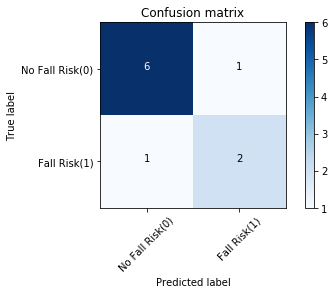

In [320]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fall Risk(0)','Fall Risk(1)'],normalize= False,  title='Confusion matrix')